In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload

In [ ]:
from fastai.vision import *
import pandas as pd
import numpy as np

In [3]:
# get_category_names
with open('/home/app/ml/grager/anno/list_category_cloth.txt', 'r') as f:
    categories = []
    for i, line in enumerate(f.readlines()):
        if i > 1:
            categories.append(line.split(' ')[0])

In [4]:
# get image category map
with open('/home/app/ml/grager/anno/list_category_img.txt', 'r') as f:
    images = []
    for i, line in enumerate(f.readlines()):
        if i > 1:
            images.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [5]:
#get train, valid, test split
with open('/home/app/ml/grager/eval/list_eval_partition.txt', 'r') as f:
    images_partition = []
    for i, line in enumerate(f.readlines()):
        if i > 1:
            images_partition.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [6]:
#check categories
categories

In [7]:
#check image list
images

In [8]:
#check partition
images_partition

In [9]:
data_df = pd.DataFrame(images, columns=['images', 'category_label'])
partition_df = pd.DataFrame(images_partition, columns=['images', 'dataset'])

In [10]:
data_df['category_label'] = data_df['category_label'].astype(int)

In [11]:
data_df = data_df.merge(partition_df, on='images')

In [12]:
data_df['dataset'].value_counts()

train    25450
val       8483
test      8482
Name: dataset, dtype: int64

In [13]:
data_df['category'] = data_df['category_label'].apply(lambda x: categories[int(x) - 1])

In [14]:
data_df['category_label'].nunique()

7

In [15]:
data_df.head()

,images,category_label,dataset,category
0,img/279-티셔츠/cap_5e24dfb95ebd0.png,4,train,티셔츠
1,img/279-티셔츠/cap_5e4091bd4a2f3.png,4,train,티셔츠
2,img/279-티셔츠/cap_5e316f14e59ac.png,4,train,티셔츠
3,img/279-티셔츠/cap_5dfc8a708e120.png,4,train,티셔츠
4,img/279-티셔츠/cap_5e1ec15929972.png,4,train,티셔츠


In [16]:
from pathlib import Path
images_path = Path('/home/app/ml/grager/')

In [17]:
data_source = (ImageList.from_df(df=data_df, path=images_path, cols='images')
                    .split_by_idxs((data_df[data_df['dataset']=='train'].index), (data_df[data_df['dataset']=='val'].index))
                    .label_from_df(cols='category')
              )

In [18]:
tmfs = get_transforms()

data = data_source.transform(tmfs, size=224).databunch(bs=16*2**3).normalize(imagenet_stats)

In [19]:
test_data = ImageList.from_df(df=data_df[data_df['dataset'] == 'test'], path=images_path, cols='images')
data.add_test(test_data)

findfont: Font family ['D2Coding'] not found. Falling back to DejaVu Sans.
/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54980 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49492 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/app/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 52768 missing from current font.
  

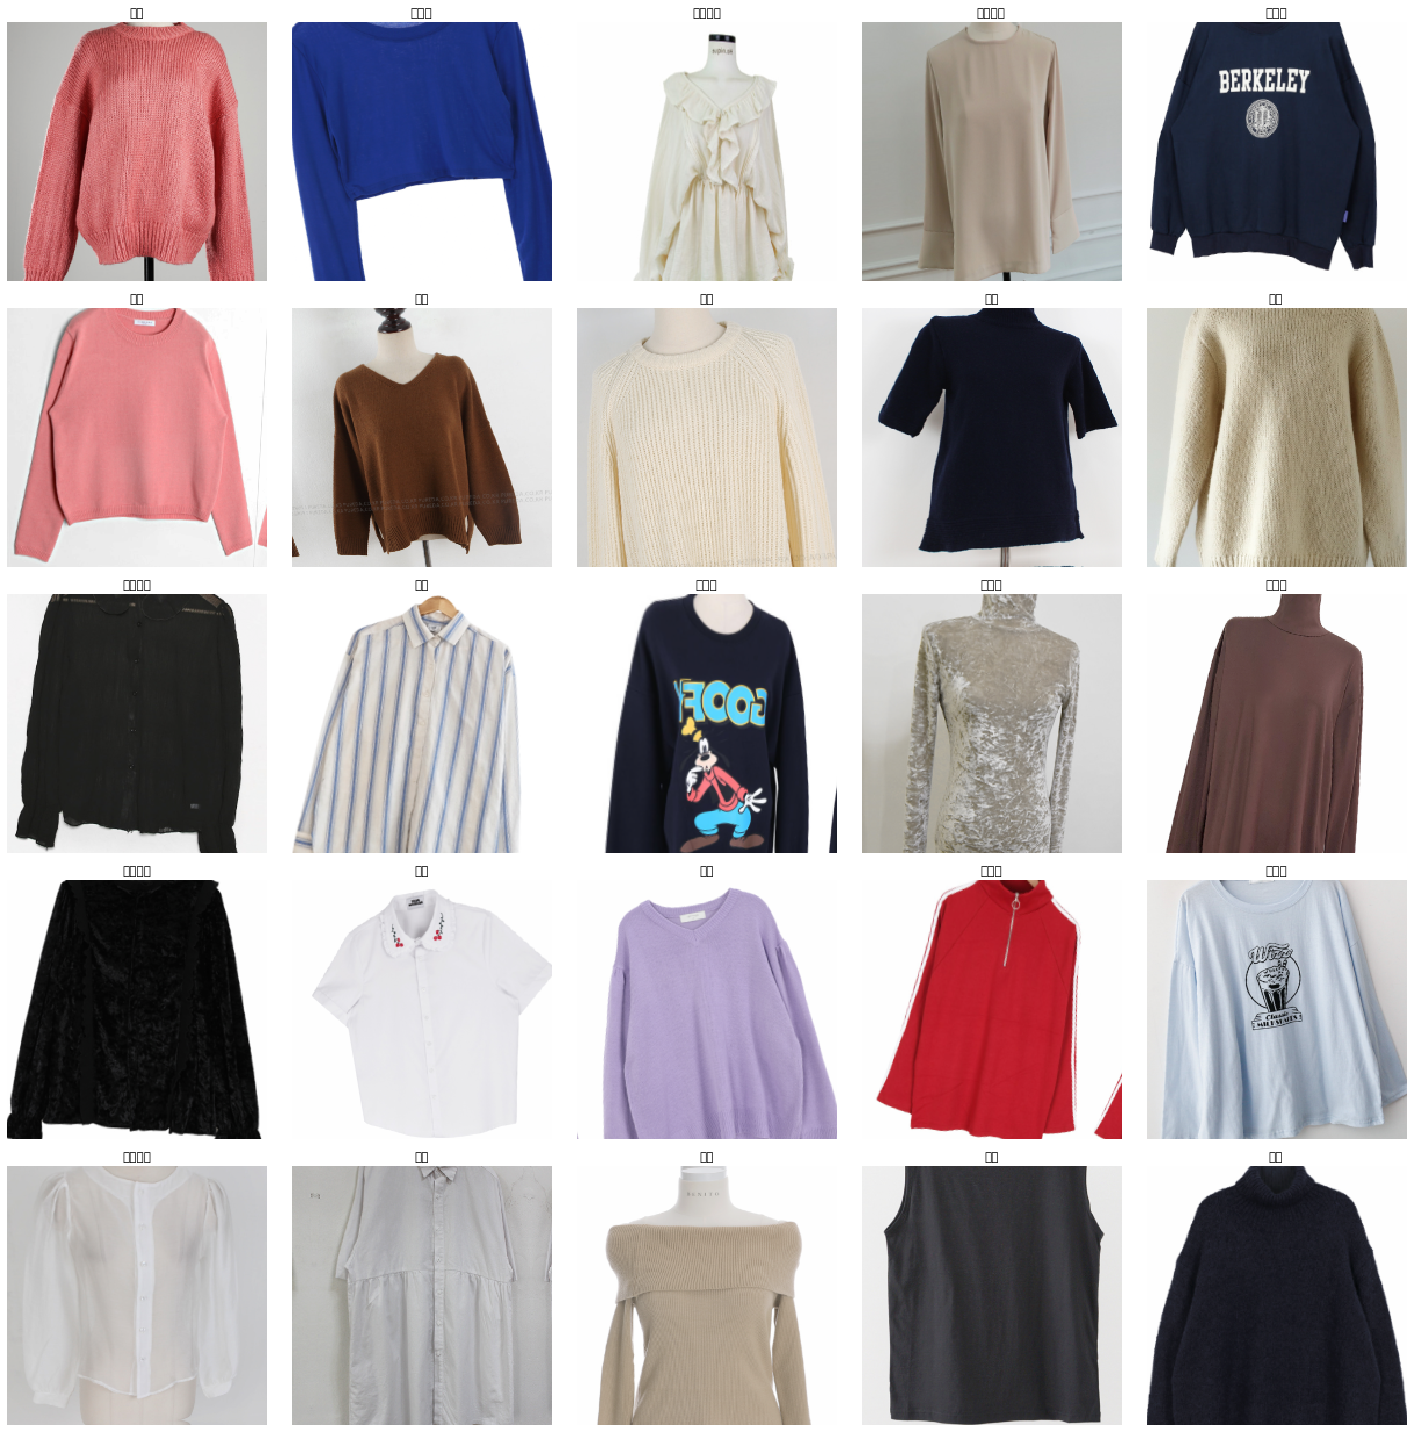

In [20]:
#font problem
data.show_batch()

In [21]:
data
#25450,8483,8482
#33933
#42415

ImageDataBunch;

Train: LabelList (25450 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
티셔츠,티셔츠,티셔츠,티셔츠,티셔츠
Path: /home/app/ml/grager;

Valid: LabelList (8483 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
티셔츠,티셔츠,티셔츠,티셔츠,티셔츠
Path: /home/app/ml/grager;

Test: LabelList (8482 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /home/app/ml/grager

In [22]:
from fastai.metrics import accuracy, top_k_accuracy

top_3_accuracy = partial(top_k_accuracy, k=3)
top_5_accuracy = partial(top_k_accuracy, k=5)

In [23]:
learner = cnn_learner(data, models.resnet152, metrics=[accuracy, top_3_accuracy, top_5_accuracy])
#os.environ["CUDA_VISIBLE_DEVICES"]='0'
#1080Ti 11GB * 3 PCI Express 8x sync
learner.model = torch.nn.DataParallel(learner.model,device_ids=[0,1,2])

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time


findfont: Font family ['D2Coding'] not found. Falling back to DejaVu Sans.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


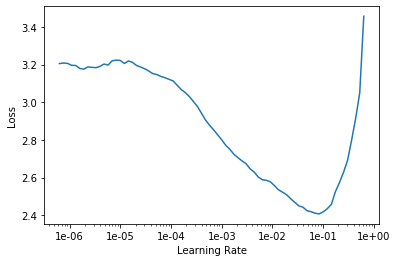

In [24]:
#finding learning rate
learner.lr_find()
learner.recorder.plot()

In [100]:
#epoch 10 times

learner.fit_one_cycle(10, max_lr=1e-03)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.585172,0.986633,0.613109,0.940705,0.983261,02:05
1,1.098105,0.785079,0.644347,0.974537,0.995638,02:04
2,0.824332,0.665368,0.673582,0.979960,0.998114,02:05
3,0.730807,0.635824,0.680891,0.985147,0.998585,02:06
4,0.666662,0.645393,0.673936,0.986090,0.998468,02:06
5,0.622534,0.597592,0.696923,0.987033,0.998468,02:05
6,0.593684,0.561883,0.698102,0.992102,0.998939,02:05
7,0.569229,0.547308,0.689025,0.992573,0.999175,02:05
8,0.535214,0.547930,0.687846,0.991395,0.998821,02:05
9,0.529549,0.547237,0.688318,0.991512,0.998821,02:06


In [101]:
#saving transfer learning
learner.save('g-resnet50-224-freezed')